## The purpose of the dev version: to add source plane
## 1. From forward modeling
## 2. From delens

In [1]:
# can I do: output = !pip install ipympl?
# !pip install ipympl

In [2]:
# this shows ipympl is not in the JaxEnv backend
# !conda list ipympl

In [3]:
#!nvidia-smi

In [4]:
from platform import python_version
print(python_version())

3.7.11


In [5]:
%matplotlib inline
# %matplotlib ipympl
from os.path import expanduser
home = expanduser("~")

import sys
sys.path.insert(0, home+'/gigalens-xh-dev/src')
sys.path.insert(0, home+'/anaconda3')


from gigalens.jax.inference import ModellingSequence
from gigalens.jax.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.jax.profiles.light import sersic
from gigalens.jax.profiles.mass import epl, shear

import tensorflow_probability.substrates.jax as tfp
import jax
from jax import random
import numpy as np
import optax
from jax import numpy as jnp
from matplotlib import pyplot as plt
import matplotlib as mpl

from lenstronomy.Plots import lens_plot
from lenstronomy.LensModel.lens_model import LensModel


import optax
tfd = tfp.distributions

# checking if using dev
import inspect
# import gigalens
import os

# print(gigalens.__file__)
print(inspect.getfile(os))
print(inspect.getfile(ModellingSequence))
print(inspect.getfile(PhysicalModel))

jax.device_count()

/global/homes/a/andigu/.conda/envs/jaxenv/lib/python3.7/os.py
/global/homes/x/xshuang/gigalens-xh-dev/src/gigalens/jax/inference.py
/global/homes/x/xshuang/gigalens-xh-dev/src/gigalens/model.py


4

In [6]:
lens_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                theta_E=tfd.LogNormal(jnp.log(1.25), 0.25),
                gamma=tfd.TruncatedNormal(2, 0.25, 1, 3),
                e1=tfd.Normal(0, 0.1),
                e2=tfd.Normal(0, 0.1),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
            )
        ),
        tfd.JointDistributionNamed(
            dict(gamma1=tfd.Normal(0, 0.05), gamma2=tfd.Normal(0, 0.05))
        ),
    ]
)
lens_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(1.0), 0.15),
                n_sersic=tfd.Uniform(2, 6),
                e1=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                e2=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
                Ie=tfd.LogNormal(jnp.log(500.0), 0.3),
            )
        )
    ]
)

source_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(0.25), 0.15),
                n_sersic=tfd.Uniform(0.5, 4),
                e1=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                e2=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                center_x=tfd.Normal(0, 0.25),
                center_y=tfd.Normal(0, 0.25),
                Ie=tfd.LogNormal(jnp.log(150.0), 0.5),
            )
        )
    ]
)

prior = tfd.JointDistributionSequential(
    [lens_prior, lens_light_prior, source_light_prior]
)


# more readable form 
def extract_params(best_params):

    mass_params = ['theta_E', 'gamma', 'e1', 'e2', 'center_x', 'center_y']
    shear_params = ['gamma1', 'gamma2']
    # if not using linear inversion -- then Ie is included
    light_params = ['R_sersic', 'n_sersic', 'e1', 'e2','center_x', 'center_y', 'Ie']
    # if using linear inversion -- then no Ie
    # light_params = ['R_sersic', 'n_sersic', 'e1', 'e2','center_x', 'center_y']

    count = 0
    for i in range(len(best_params)):
        if i==0:
            print('Lens mass params ({:d} sets):'.format(len(best_params[i])))
        elif i==1:
            print('Lens light params({:d} sets):'.format(len(best_params[i])))
        elif i==2:
            print('Source light params({:d} sets):'.format(len(best_params[i])))
        for j in range(len(best_params[i])):
            if j > 0:
                print()
            for k in range(len(best_params[i][j])):
                if i==0:
                    if j==0:
                        print('{:5s}={:6.3f}  '.format(mass_params[k], best_params[i][j][mass_params[k]]), end='')
                    elif j==1:
                        print('{:5s}={:6.3f}  '.format(shear_params[k], best_params[i][j][shear_params[k]]), end='')

                else:
                    print('{:5s}={:6.3f}  '.format(light_params[k], best_params[i][j][light_params[k]]), end='')

                count += 1
        print('\n')


beta for lens #0
lens EPL
lens params {'center_x': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/2)>, 'center_y': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/2)>, 'e1': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/2)>, 'e2': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/2)>, 'gamma': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/2)>, 'theta_E': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/2)>}
beta for lens #1
lens SHEAR
lens params {'gamma1': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/2)>, 'gamma2': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/2)>}


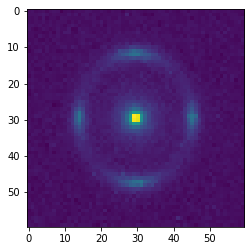

theta_E location in pixels: 46.0


In [7]:
delta_pix = 0.065
num_pix = 60
ctr = num_pix//2
supersample = 2

kernel = np.load('./src/gigalens/assets/psf.npy').astype(np.float32)
sim_config = SimulatorConfig(delta_pix=delta_pix, num_pix=num_pix, supersample=supersample, kernel=kernel)
phys_model = PhysicalModel([epl.EPL(50), shear.Shear()], [sersic.SersicEllipse(use_lstsq=False)], [sersic.SersicEllipse(use_lstsq=False)])
lens_sim = LensSimulator(phys_model, sim_config, bs=1)

background_rms, exp_time = 0.2, 100


theta_E = 1.1
# # Now I make up other systems

truth = [[
    {'theta_E': theta_E, 'gamma': 2.0, 'e1': 0.2, 'e2': 1e-6, 'center_x': 0.0, 'center_y': 0.0},
    {'gamma1': 1e-6, 'gamma2': 1e-6}
], [
    {'R_sersic': 0.8, 'n_sersic': 4.0, 'e1': 1e-6, 'e2': 1e-6, 'center_x': 1e-6, 'center_y': 2e-6, 'Ie': 100.}
], [
    {'R_sersic': 0.1, 'n_sersic': 1.0, 'e1': 0., 'e2': 0., 'center_x': 0.0, 'center_y': 0.0, 'Ie': 500.}
]]

noiseless_img = lens_sim.simulate(truth)
observed_img = noiseless_img + \
                np.random.normal(0, background_rms, noiseless_img.shape) + \
                np.random.poisson(noiseless_img/exp_time, noiseless_img.shape)
plt.imshow(observed_img)

# observed_img = np.load('./src/gigalens/assets/demo.npy')
prob_model = ForwardProbModel(prior, observed_img, background_rms=background_rms, exp_time=exp_time)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)

# plt.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)

plt.imshow(observed_img)
plt.show()

print('theta_E location in pixels:', theta_E//delta_pix + ctr)

In [19]:
# on M1, 100 samples, 200 steps: 5 min to run -- so be careful

map_samples = 300

map_steps = 1000
transition_steps = 1000

seed, lr_start, lr_end, pwr = 0, -10e-2, -5e-2/10, 0.5

schedule_fn = optax.polynomial_schedule(init_value=lr_start, end_value=lr_end, 
                                      power=pwr, transition_steps=transition_steps)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)
map_estimate, chi2_hist = model_seq.MAP(opt, seed=0, n_samples=map_samples, num_steps=map_steps)
# map_estimate = model_seq.MAP(opt, seed=0, n_samples=30, num_steps=num_steps)

DEV version!!!


  0%|          | 0/1000 [00:00<?, ?it/s]

beta for lens #0
lens EPL
lens params {'center_x': Traced<ShapedArray(float32[75])>with<JVPTrace(level=2/4)> with
  primal = Traced<ShapedArray(float32[75])>with<JaxprTrace(level=1/4)> with
    pval = (None, Traced<ShapedArray(float32[75])>with<DynamicJaxprTrace(level=0/4)>)
    recipe = *
  tangent = Traced<ShapedArray(float32[75])>with<JaxprTrace(level=1/4)> with
    pval = (ShapedArray(float32[75]), Traced<AbstractUnit()>with<DynamicJaxprTrace(level=0/4)>)
    recipe = LambdaBinding(), 'center_y': Traced<ShapedArray(float32[75])>with<JVPTrace(level=2/4)> with
  primal = Traced<ShapedArray(float32[75])>with<JaxprTrace(level=1/4)> with
    pval = (None, Traced<ShapedArray(float32[75])>with<DynamicJaxprTrace(level=0/4)>)
    recipe = *
  tangent = Traced<ShapedArray(float32[75])>with<JaxprTrace(level=1/4)> with
    pval = (ShapedArray(float32[75]), Traced<AbstractUnit()>with<DynamicJaxprTrace(level=0/4)>)
    recipe = LambdaBinding(), 'e1': Traced<ShapedArray(float32[75])>with<JVPTrace

In [20]:
from datetime import datetime
import pickle
date = datetime.now().strftime("%Y_%m_%d-%H:%M")

hyper_params = [map_steps, transition_steps, seed, lr_start, lr_end, pwr]

with open(f"map_est_{date}_sim.pickle", 'wb') as f:
    pickle.dump((map_estimate, chi2_hist, hyper_params), f)

map_estimate.shape, map_steps, transition_steps

((300, 22), 1000, 1000)

In [20]:

lens_sim = LensSimulator(phys_model, sim_config, bs=len(map_estimate))
# these two lines can take long to run on cpu
# 
lps, chi2 = prob_model.log_prob(lens_sim, map_estimate)
# recon = lens_sim.lstsq_simulate(prob_model.bij.forward(list(map_estimate.T)), 
#                                 obs_data, prob_model.err_map)[np.nanargmax(lps)]

best_params = prob_model.bij.forward(list(map_estimate[np.nanargmax(lps)]))

print(map_estimate.shape)
print(np.nanargmax(lps))
print(map_estimate[np.nanargmax(lps)].shape)


beta for lens #0
beta for lens #1
(100, 22)
41
(22,)


In [ ]:
chi2_arr = np.array(chi2_hist)
chi2_min = chi2_arr.min()
map_samples = map_estimate.shape[0]
# map_steps, transition_steps, seed = hyper_params

# map_steps, transition_steps, seed, lr_start, lr_end, pwr = hyper_params

lr_start, lr_end, pwr = -1e-2, -1e-2/4, 0.5

plt.figure(figsize=(5, 4))
plt.plot(chi2_hist)
plt.yscale('log')
plt.text(map_steps*0.5, chi2_min*1.4, 'chi2_min:{:.3f}'.format(chi2_min))
hyper_p = 'map_samples:{:d} \n\
map_steps:{:d}  \n \
transition_steps:{:d} \n'.format(map_samples, map_steps, transition_steps) #, seed, lr_start, lr_end, pwr) 
# hyper_p = 'map_samples:{:d} \n'.format(map_samples) #, map_steps, transition_steps, seed, lr_start, lr_end, pwr) 

plt.text(map_steps*0.5, chi2_min, hyper_p)
# plt.ylim(2.5, 6)
plt.ylim(0.9, 20)
plt.show()


In [ ]:
# note in the instantiation of prob_model, the observed_img is used (though I'm not sure why)
# prob_model = ForwardProbModel(prior, observed_img, background_rms=background_rms, exp_time=exp_time)
# model_seq = ModellingSequence(phys_model, prob_model, sim_config)

## Add source plane reconstruction

## Also find the light amplitude, Ie, in the case when linear inversion is used (otherwise it's one of the fitting parameters)

In [ ]:
# note here, we didn't use linear inversion so the brigtness, Ie, was fit for too.
# best_params = prob_model.bij.forward(list(map_estimate[np.nanargmax(lps)]))   
        
# extract_params(best_params)
# print('Compared with truth: \n')

print('The truth parameters:')
extract_params(truth)
# chi2_ar = chi2_arr[-100:]
# print('min chi2: {:4.3f}'.format(chi2_arr.min()))

In [ ]:
# compare best-fit parameters with observed image
from astropy import modeling

plt.figure(figsize=(15, 3))
plt.subplot(141)
plt.imshow(lens_sim.simulate(truth), norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)
# plt.colorbar()
plt.axis('off')
plt.subplot(142)
simulated = lens_sim.simulate(truth)
plt.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)

plt.subplot(143)
resid = simulated - observed_img
background_rms, exp_time = 0.2, 100
err_map = np.sqrt(background_rms**2 + simulated/exp_time)

norm_resid = np.asarray(resid/err_map)

plt.imshow(norm_resid, cmap='coolwarm', interpolation='none', vmin=-5, vmax=5)
plt.axis('off')
plt.colorbar()

plt.subplot(144)
bin_h, bins, _ = plt.hist(norm_resid.flatten(), bins=100)
x = (bins[:-1] + bins[1:])/2
fitter = modeling.fitting.LevMarLSQFitter()
model = modeling.models.Gaussian1D()   # depending on the data you need to give some initial values
fitted_model = fitter(model, x, bin_h)

plt.plot(x, fitted_model(x))
plt.title(r'$\mu$ = {:.3f}, $\sigma$ = {:.3f}'.format(fitted_model.mean.value, fitted_model.stddev.value))

print('Chi-square:', np.mean((resid/err_map)**2))




In [ ]:
plt.imshow(lens_sim.simulate(truth), norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)


In [ ]:
from copy import copy
no_lens = copy(truth)
no_lens[0][0]['theta_E'] = 1e-12
no_lens

# next use WS code to get the source plane 

# Why does the source position doesn't seem to be very close to the center of the caustic?
# Check if the source position is right? Since I'm using the truth here.

lens params: [{'theta_E': 1.1, 'gamma': 2.0, 'e1': 0.2, 'e2': 1e-06, 'center_x': 0.0, 'center_y': 0.0}, {'gamma1': 1e-06, 'gamma2': 1e-06}]
source light params: [{'R_sersic': 0.01, 'n_sersic': 2.0, 'e1': 0.0, 'e2': 0.0, 'center_x': 0.0, 'center_y': 0.0, 'Ie': 5000.0}]
(100,)
num_pix, delta_pix, scale_extent, ext_arcsec: 61 0.065 2.0 2.015
extent (2.015, -2.015, -2.015, 2.015)


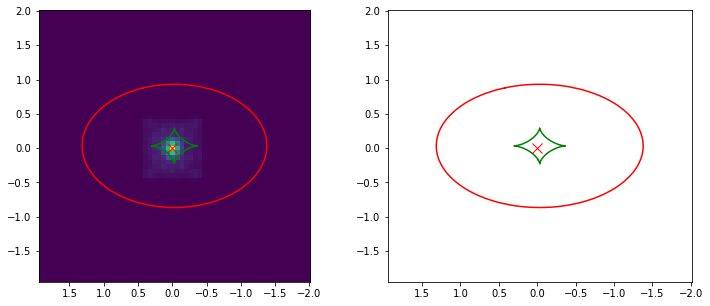

In [8]:
lensModel = LensModel(lens_model_list=['EPL', 'SHEAR'], multi_plane=False)
kwargs_lens = truth[0]

print('lens params:', truth[0])

# phys_model_t = PhysicalModel([], [sersic.SersicEllipse(use_lstsq=False)], [])
# sim_config_t = SimulatorConfig(delta_pix=delta_pix, num_pix=num_pix, supersample=supersample, kernel=kernel)
# lens_sim_t = LensSimulator(phys_model_t, sim_config_t, bs=1)
# x = lens_sim_t.simulate([truth[0], truth[2], []])
# x = lens_sim_t.simulate(truth)
# off = -(size-2)


print('source light params:', truth[2])


print(x.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

lens_plot.lens_model_plot(ax1, lensModel=lensModel, kwargs_lens=kwargs_lens, with_caustics=True, fast_caustic=True, coord_inverse=True, with_convergence=False, deltaPix=delta_pix, numPix=num_pix, )
simulated = lens_sim.simulate([[], truth[2], []])

scale_extent = 2.0
ext_arcsec = ((num_pix+1)*delta_pix)/scale_extent
print('num_pix, delta_pix, scale_extent, ext_arcsec:', num_pix, delta_pix, scale_extent, ext_arcsec)

extent = ext_arcsec, -ext_arcsec, -ext_arcsec, ext_arcsec
print('extent', extent)

ax1.plot(0, 0, 'x', ms=10, color='red')
ax1.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=1), extent=extent)

lens_plot.lens_model_plot(ax2, lensModel=lensModel, kwargs_lens=kwargs_lens, with_caustics=True, fast_caustic=True, coord_inverse=True, with_convergence=False, deltaPix=delta_pix, numPix=num_pix, )
ax2.plot(0, 0, 'x', ms=10, color='red')




# ax.imshow(simulated, vmin=0, vmax=1, extent=extent)

# # source_img = np.rot90(np.rot90(x))
# source_img = x

# ax.imshow(source_img, norm=mpl.colors.PowerNorm(0.5, vmin=3.0, vmax=3.5), extent=extent)

In [98]:
simulated.max()

DeviceArray(1.0568318, dtype=float32)

lens params: [{'theta_E': 1e-12, 'gamma': 1.8, 'e1': 0.1, 'e2': 1e-06, 'center_x': 0.0, 'center_y': 0.0}, {'gamma1': 1e-06, 'gamma2': 1e-06}]
lens_light_params []
source_light_params [{'Ie': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'R_sersic': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'center_x': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'center_y': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'e1': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'e2': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'n_sersic': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>}]
lens_light_params [{'Ie': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'R_sersic': Traced<ShapedArray(float32[], weak_type=True)>with<Dyn

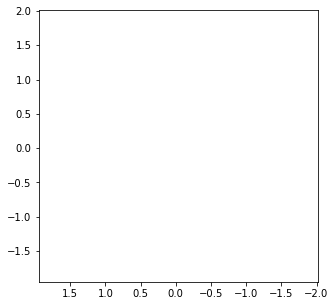

In [37]:
lensModel = LensModel(lens_model_list=['EPL', 'SHEAR'], multi_plane=False)
kwargs_lens = truth[0]

print('lens params:', truth[0])


arcs_img = lens_sim.simulate([truth[0], [], truth[2]])
source_img = lens_sim.simulate([no_lens[0], truth[2], []])

# plt.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)



# phys_model_t = PhysicalModel([], [sersic.SersicEllipse(use_lstsq=False)], [])
# sim_config_t = SimulatorConfig(delta_pix=delta_pix, num_pix=num_pix, supersample=2, kernel=kernel)
# lens_sim_t = LensSimulator(phys_model_t, sim_config_t, bs=1)
# source_img = lens_sim_t.simulate([[], truth[2], []])
# arcs_img = lens_sim_t.simulate([truth[0], truth[1], truth[2]])

source_arcs = source_img + arcs_img

# off = -(size-2)

print('source light params:', truth[2])

# print(x.shape)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

lens_plot.lens_model_plot(ax, lensModel=lensModel, kwargs_lens=kwargs_lens, with_caustics=True, fast_caustic=True, coord_inverse=True, with_convergence=False, deltaPix=delta_pix, numPix=num_pix, )

# scale_extent = 2

# extent = (num_pix*delta_pix)/scale_extent, -(num_pix*delta_pix)/scale_extent, \
#          -(num_pix*delta_pix)/scale_extent, (num_pix*delta_pix)/scale_extent,

# # source_img = np.rot90(np.rot90(source_img))
# # extent = -(num_pix*delta_pix), (num_pix*delta_pix), -(num_pix*delta_pix), (num_pix*delta_pix)


# # ax.imshow(source_arcs, norm=mpl.colors.PowerNorm(0.5, vmin=3.0, vmax=3.5), extent=extent)
# ax.plot(truth[2][0]['center_x'], truth[2][0]['center_y'], '*', color='gray', ms=10)
# ax.imshow(arcs_img, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20), extent=extent) #, cmap='GnBu')
# ax.grid(axis='both')


# ax2 = ax.twinx().twiny() #here is the trick!
# ax2.imshow(arcs_img, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20)) #, cmap='GnBu')

# # ax2.tick_params(axis='both', labelcolor='blue')
# ax2.tick_params(top=True, labeltop=True, right=True, labelright=True)
# # Major ticks
# ax2.set_xticks(np.arange(0, 60, 1))
# ax2.set_yticks(np.arange(0, 60, 1))

# # Labels for major ticks
# ax2.set_xticklabels(np.arange(1, 61, 1))
# ax2.set_yticklabels(np.arange(1, 61, 1))
# # ax2.grid(which='major', axis='both')
# # ax2.set_xticks(np.linspace(0, 59, 6))
plt.show()

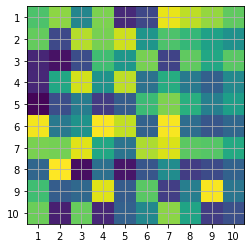

In [38]:
plt.figure()
im = plt.imshow(np.reshape(np.random.rand(100), newshape=(10,10)),
                interpolation='none', vmin=0, vmax=1, aspect='equal')

ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 11, 1))
ax.set_yticklabels(np.arange(1, 11, 1))

# # Minor ticks
# ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
# ax.set_yticks(np.arange(-.5, 10, 1), minor=True)

# Gridlines based on minor ticks
# ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.grid(which='major')

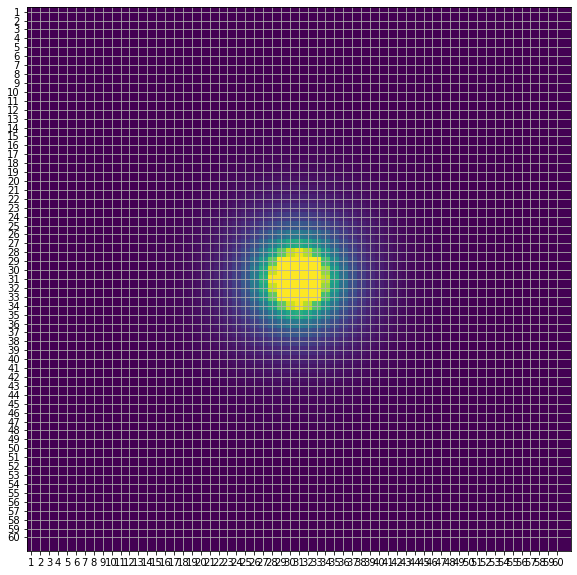

In [39]:
plt.figure(figsize=(10, 10))
im = plt.imshow(arcs_img,
                interpolation='none', vmin=0, vmax=1, aspect='equal')

ax = plt.gca()

# Major ticks
ax.set_xticks(np.arange(0, 60, 1))
ax.set_yticks(np.arange(0, 60, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 61, 1))
ax.set_yticklabels(np.arange(1, 61, 1))

# # Minor ticks
# ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
# ax.set_yticks(np.arange(-.5, 10, 1), minor=True)

# Gridlines based on minor ticks
# ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.grid(which='major')

# ax.imshow(arcs_img)

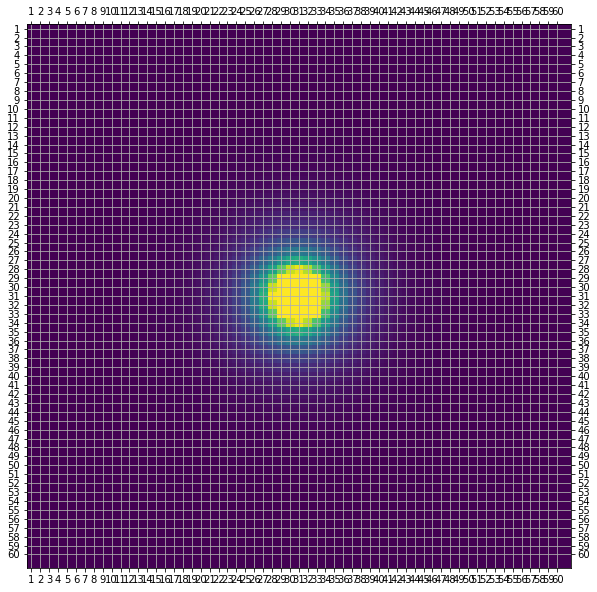

In [40]:
plt.figure(figsize=(10, 10))
im = plt.imshow(arcs_img,
                interpolation='none', vmin=0, vmax=1, aspect='equal')

ax = plt.gca()
ax.tick_params(top=True, labeltop=True, right=True, labelright=True)

# Major ticks
ax.set_xticks(np.arange(0, 60, 1))
ax.set_yticks(np.arange(0, 60, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 61, 1))
ax.set_yticklabels(np.arange(1, 61, 1))

ax.grid(which='major')


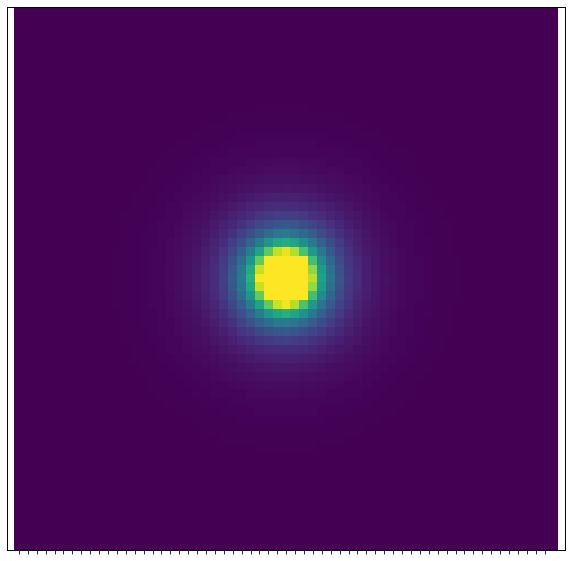

In [41]:
plt.figure(figsize=(10, 10))
im = plt.imshow(arcs_img,
                interpolation='none', vmin=0, vmax=1, aspect='equal')

ax = plt.gca()
ax.tick_params(left=False, labelleft=False, \
               bottom=False, labelbottom=False, \
               top=False, labeltop=False, \
               right=False, labelright=False)


# Major ticks
ax.set_xticks(np.arange(0, 60, 1))
ax.set_yticks(np.arange(0, 60, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 61, 1))
ax.set_yticklabels(np.arange(1, 61, 1))

# ax.grid(which='major')

ax2 = ax.twiny() #here is the trick!
ax2.tick_params(left=False, labelleft=False, \
               bottom=False, labelbottom=False, \
               top=False, labeltop=False, \
               right=False, labelright=False)

# ax2.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False, top=False, labeltop=False, right=False, labelright=False)
# # Major ticks
# # ax2.set_xticks(np.arange(0, 60, 1))
# ax2.set_yticks(np.arange(0, 60, 1))

# # Labels for major ticks
# # ax2.set_xticklabels(np.arange(1, 61, 1))
# ax2.set_yticklabels(np.arange(1, 61, 1))
# ax2.grid(which='major', axis='x')


In [42]:
truth[2][0]

{'R_sersic': 0.25,
 'n_sersic': 1.5,
 'e1': 0.0,
 'e2': 0.0,
 'center_x': 0.0,
 'center_y': 0.0,
 'Ie': 150.0}

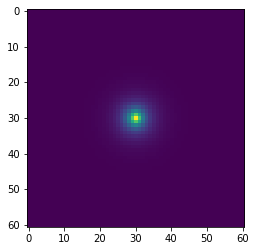

In [43]:
arcs_img = lens_sim.simulate([truth[0], [], truth[2]])
plt.imshow(arcs_img)

lens_light_params [{'Ie': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'R_sersic': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'center_x': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'center_y': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'e1': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'e2': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'n_sersic': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>}]
source_light_params []


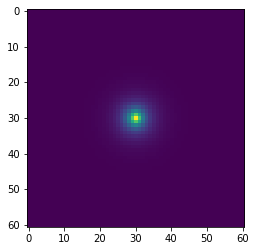

In [44]:
source_img = lens_sim.simulate([[], truth[2], []])
plt.imshow(source_img + arcs_img)

## Next: add cautic and critical curves -- reproduce one of the four archetypes

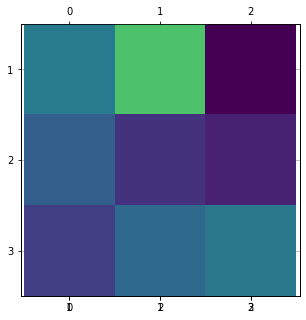

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

nx, ny = 3, 3

np.random.seed(seed=1)
img = np.reshape(np.random.rand(nx*ny), newshape=(nx, ny))

im = ax.imshow(img, interpolation='none', vmin=0, vmax=1, aspect='equal')

# Major ticks
ax.set_xticks(np.arange(0, nx, 1))
ax.set_yticks(np.arange(0, ny, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, nx+1, 1))
ax.set_yticklabels(np.arange(1, ny+1, 1))

# # Minor ticks
# ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
# ax.set_yticks(np.arange(-.5, 10, 1), minor=True)

# Gridlines based on minor ticks
# ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.grid(which='major', axis='both')

ax2 = ax.twiny() #here is the trick!

# ax2.tick_params(top=True, labeltop=True, right=True, labelright=True)
# # Major ticks
ax2.set_xticks(np.arange(0, nx, 1))
ax2.set_yticks(np.arange(0, ny, 1))

# # Labels for major ticks
# ax2.set_xticklabels(np.arange(1, nx+1, 1))
# ax2.set_yticklabels(np.arange(1, ny+1, 1))
ax2.imshow(img, interpolation='none', vmin=0, vmax=1, aspect='equal')


ax2.grid(which='major', axis='y')



ax3 = ax2.twiny() #here is the trick!

# ax2.tick_params(top=True, labeltop=True, right=True, labelright=True)
# # Major ticks
ax3.set_xticks(np.arange(0, nx, 1))
ax3.set_yticks(np.arange(0, ny, 1))

# # Labels for major ticks
# ax2.set_xticklabels(np.arange(1, nx+1, 1))
# ax2.set_yticklabels(np.arange(1, ny+1, 1))
ax3.imshow(img, interpolation='none', vmin=0, vmax=1, aspect='equal')


ax3.grid(which='major', axis='y')
plt.show()

